- Image search -
Involves :
CNN, Deep Learning model, Tensorflow 1, Distance metrics, Convolutional blocks, Dense blocks, Checkpoints

It is a CNN for image classification, using the CIFAR-10 dataset (60000 images of size 32x32, 10 classes).
After training it, the model allows us to find in which class a new image belongs to.
In this notebook we see the results of the deep learning model and its accuracy.
In the same GitHub repository you will soon find a Flask app version of this model, where the user can upload an image and see the results.

In [1]:
import numpy as np
import os       # to work with files
import cv2      # to read and resize images
import matplotlib.pyplot as plt
import pandas as pd
import pickle   # for storage option
import seaborn as sns

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
#(or)
#tf.compat.v1.disable_v2_behavior()
#from tensorflow import keras
#from tqdm import tqdm_notebook   # help visualize training process

from tqdm.notebook import tqdm_notebook
from scipy.spatial.distance import hamming, cosine   # to compare vectors

# keep all the visualizations into the notebook file
%matplotlib inline

### Data preprocessing
###### Load image + Preprocess dataset

##### 1 - Load image

In [2]:
def image_loader(image_path, image_size):
    '''
    Load an image from the disk.
    
    image_path:String -> path to the image
    image_size:Tuple -> size of an output image, example : (32, 32)
    '''
    
    # to read an image from the disk
    image = cv2.imread(image_path)
    
    # cv2 library loads images in BGR format, need to convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # resizing the image
    # here we use CUBIC interpolation (way to fill a missing data) to resize the image
    image = cv2.resize(image, image_size, cv2.INTER_CUBIC)
    
    return image    

##### 2 - Preprocess dataset

In [3]:
def dataset_preprocessing(dataset_path, labels_file_path, image_size, image_paths_pickle):
    '''
    Load images and labels from the folder containing the dataset.
    This function gets the different classes and list them,
    calls the image_loader() function and list the paths of each image,
    gives an index for each class,
    and saves all the paths in a pickle file. This pickle file will be used to save and load objects.
    The function returns an array of images and an array of labels (encoded from 0 to 9 for CIFAR-10 dataset)
    
    dataset_path:String -> path to the train/test dataset folder
    labels_file_path:String -> path to the .txt file containing classes names
    image_size:Tuple -> single image size
    image_paths_pickle:String -> name of a pickle file where all image paths will be saved
    '''
    
    # get all classes in the dataset
    with open(labels_file_path, "r") as f:
        classes = f.read().split("\n")[:-1]  # list of all 10 classes. each line is a class name.
        # [:-1] to remove the last element which is a ""
    #print(classes)
    
    images = []  # hold all the images
    labels = []  # hold all respective classes for each image
    image_paths = []   # hold path for each image, list is stored in the pickle file
    
    # go through all the images in the dataset folder
    for image_name in os.listdir(dataset_path):
        try:
            image_path = os.path.join(dataset_path, image_name)   # example : cifar/train/0_frog.png
            images.append(image_loader(image_path, image_size))
            image_paths.append(image_path)  # append the images' paths to the paths list
            
            # go through all the classes and check if the class name appears in the image name
            for index in range(len(classes)):
                if classes[index] in image_name:   # ex° : if 'frog' is in '0_frog.png'
                    labels.append(index)   # if there's a match, we append the index in the list of labels
                    # labels are encoded in this list
                    
        except:
            pass
    
    # save all the paths in the pickle
    with open(image_paths_pickle + ".pickle", "wb") as f:
        pickle.dump(image_paths, f)
    
    assert len(images) == len(labels)   # make sure same amount of elements in 'images' and 'labels' lists
    # if this statement is false, the rest of the code won't be executed.
    
    return np.array(images), np.array(labels)

    

In [4]:
images, labels = dataset_preprocessing("cifar/train/", \
                      "cifar/labels.txt", \
                      (32, 32), \
                      "cifar/training_images_pickle"                      
                     )

#(takes some time)

In [5]:
labels.shape
labels[:100]

array([6, 1, 6, 6, 8, 8, 3, 4, 6, 0, 6, 9, 0, 3, 6, 6, 5, 4, 8, 3, 2, 6,
       4, 0, 3, 1, 4, 0, 6, 6, 2, 7, 6, 3, 9, 0, 4, 5, 7, 1, 6, 7, 9, 1,
       2, 7, 7, 8, 0, 3, 7, 4, 7, 3, 1, 4, 0, 4, 6, 6, 1, 4, 9, 2, 6, 4,
       4, 5, 0, 4, 6, 0, 8, 3, 4, 8, 8, 1, 3, 9, 5, 7, 1, 9, 4, 7, 9, 1,
       4, 9, 7, 5, 2, 7, 3, 4, 8, 8, 2, 2])

In [6]:
images.shape
# (50000, 32, 32, 3)
# there are 50000 images of size 32x32 in RGB format

(50000, 32, 32, 3)

C:\Users\camib\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

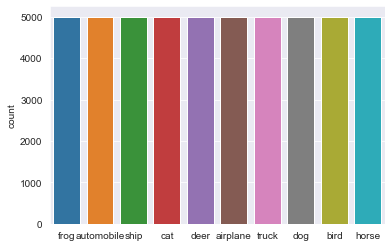

In [7]:
# histogram of the number of elements of each class
h = []
for i in range(len(labels)):
    #print(i)
    if (labels[i]==0):
        h.append('airplane')
    if (labels[i]==1):
        h.append('automobile')
    if (labels[i]==2):
        h.append('bird')
    if (labels[i]==3):
        h.append('cat')
    if (labels[i]==4):
        h.append('deer')
    if (labels[i]==5):
        h.append('dog')
    if (labels[i]==6):
        h.append('frog')
    if (labels[i]==7):
        h.append('horse') 
    if (labels[i]==8):
        h.append('ship')
    if (labels[i]==9):
        h.append('truck')      
    else:
        pass
sns.set_style('darkgrid')
sns.countplot(h)

# we can see that each class is equally distributed, which makes the learning fair

### Vectors distances functions

In [8]:
# Cosine distance
# to compare images -> see similarities between images' vectors by measuring the cosine distance
'''
Calculates cosine distances between query image (vectors) and all training set images (vectors).

training_set_vectors:Numpy Matrix -> vectors for all images in the training set
query_vector:Numpy vector -> our new image vector
top_n=50:Integer -> nb of closest images to return
'''

def cosine_distance(training_set_vectors, query_vector, top_n=50):
    
    distances = []   # all the calculated distances stored in the list
    
    for i in range(len(training_set_vectors)):   # 50.000 images for Cifar-10 ds
        distances.append(cosine(training_set_vectors[i], query_vector[0]))    # cosine(u, v)
        
    return np.argsort(distances)[:top_n]   #sorted indices
    # takes an array and sort it, and returns sorted indices instead of a sorted array


In [9]:
# Hamming distance
# works in binary vectors only, unlike cosine distance
'''
Calculates hamming distances between query image (vectors) and all training set images (vectors).

training_set_vectors:numpy Matrix -> vectors for all images in the training set
query_vector:numpy vector -> query image (new image) vector
top_n=50:integer -> nb of closest images to return
'''

def hamming_distance(training_set_vectors, query_vector, top_n=50):
    
    distances = [] 
    
    for i in range(len(training_set_vectors)):   # 50.000 images for Cifar-10 ds
        distances.append(hamming(training_set_vectors[i], query_vector))  
        
    return np.argsort(distances)[:top_n]  


### Accuracy function

In [10]:
# Sparse accuracy to check how accurate our model is (how often it predicts the correct classes)
''' 
Calculates accuracy of a model based on softmax outputs.

true_label:Numpy array -> real labels of each sample
predicted_labels:Numpy matrix -> softmax probabilities
'''

def sparse_accuracy(true_labels, predicted_labels):
    
    assert len(true_labels) == len(predicted_labels)
    
    correct = 0
    for i in range(len(true_labels)):
        if np.argmax(predicted_labels[i]) == true_labels[i]:
        # takes an array and return index of highest proba and compares it to the index of the true label
        # if true, add one to the correct predictions
            correct += 1
        
    return correct / len(true_labels)

### Model inputs function

In [18]:
import tensorflow.compat.v1 as tf   # by default in TF2, tf.executing_eagerly() -> True
print(tf.__version__)

2.4.1


In [19]:
tf.disable_v2_behavior()   # that makes tf.executing_eagerly() -> False
#tf.enable_eager_execution()   # that re-makes tf.executing_eagerly() -> True again
tf.executing_eagerly()

Instructions for updating:
non-resource variables are not supported in the long term


False

In [20]:
# We define placeholders for the inputs

def model_inputs(image_size):
    '''
    Define CNN inputs (placeholders).
    
    image_size:Tuple -> (height, width) of an image  # here (32, 32)
    '''
    
    # for TensorFlow 1 :
    # placeholder that receives the images
    inputs = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, image_size[0], image_size[1], 3], name='images')
    # Batch size set to 'None' which allows us to import any nb of images
    
    targets = tf.compat.v1.placeholder(dtype=tf.int32, shape=[None], name='targets')
    
    dropout_rate = tf.compat.v1.placeholder(dtype=tf.float32, name='dropout_rate')

    return inputs, targets, dropout_rate

We define two functions for our layers : a convolutional block function and a dense block (or fully connected layers) function.
When we call the convolutional block function, a convolution followed by a max-pooling and a batch normalization are applied on our images.
When we call the dense block function, connections between layers are made, followed by a dropout to regularize, and a batch normalization.

### Convolutional block function

In [21]:
# Convolutional block function

def conv_block(inputs,
               number_of_filters,
               kernel_size,
               strides=(1, 1),
               padding='SAME',
               activation=tf.nn.relu,
               max_pool=True,
               batch_norm=True):
        
    '''
    Defines convolutional block layer.
    
    inputs -> data from previous layer
    number_of_filters:integer -> number of conv filters
    kernel_size:tuple -> size of conv layer kernel
    padding:string -> type of padding techniques: SAME or VALID
    activation:tf.object -> activ function used on the layer
    max_pool:boolean -> if True the conv block will use batch norm
    '''
    
    # define features separately from the layer, so we can represent images with vectors
    conv_features = layer = tf.layers.conv2d(inputs=inputs, 
                                             filters=number_of_filters, 
                                             kernel_size=kernel_size, 
                                             strides=strides, 
                                             padding=padding,
                                             activation=activation)
    
    # check whether a conv block will be using a max pooling or not
    if max_pool:
        layer = tf.layers.max_pooling2d(layer,
                                        pool_size=(2, 2),
                                        strides=(2, 2),  #want to decrease the size of the layer by two 
                                        padding='SAME') 
        
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)
        
        
    return layer, conv_features
    # we need specific representation of the images (that comes from the layers themselves), given by conv_features

### Dense block function (fully connected layers)

In [22]:
# has 3 parts : fully connected part, dropout part, batch normalization

def dense_block(inputs, 
                units, 
                activation=tf.nn.relu, 
                dropout_rate=None, 
                batch_norm=True):

    '''
    Defines dense block layer.
    
    inputs -> data from previous layer
    units:integer -> nb of neurons/units for a dense layer
    activation:tf.object -> activ function used on the layer
    dropout_rate -> dropout rate used in this dense block
    batch_norm:boolean -> if True the conv block will use batch normalization
    '''
    
    # define features separately from the layer, so we can represent images with vectors
    dense_features = layer = tf.layers.dense(inputs=inputs,
                                                   units=units,
                                                   activation=activation)
    

    # dropout_rate is None by default. In our case it's a tf.placeholder, so not None
    # we apply then the dropout to our dense layer
    if dropout_rate is not None:
        layer = tf.layers.dropout(layer,
                                  rate=dropout_rate)
                                         
    
    if batch_norm:
        layer = tf.layers.batch_normalization(layer)

    return layer, dense_features
    

### Optimization and loss functions

In [23]:
def opt_loss(logits,
            targets,
            learning_rate):
    
    '''
    Defines model's optimizer and loss functions.
    
    logits -> pre-activated outputs from the last layer of the model
    targets -> true labels for each input sample
    learning_rate
    '''

    # sparse -> we don't have to convert our targets to their one hot encoding versions
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=logits))
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss) # Adam peforms the best for CNNs
    
    return loss, optimizer

### Model architecture

In [24]:
class ImageSearchModel(object):
    
    def __init__(self,
                learning_rate,
                image_size,
                number_of_classes=10):
        '''
        Defines CNN model.
        
        learning_rate
        image_size:tuple -> (height, width) of an image
        number_of_classes:integer -> nb of classes in a ds
        '''

        # reset the tensorflow graph each time the model is defined to avoid nested models
        tf.reset_default_graph()
        #tf.compat.v1.reset_default_graph()
        
        # define model inputs
        self.inputs, self.targets, self.dropout_rate = model_inputs(image_size)
        # 'model_inputs' function is defined above, it returns 3 elements
        
        # no function for image normalization so they are between 0 and 255
        # to overcome this : batch normalization layer before the conv layer :
       
        normalized_images = tf.layers.batch_normalization(self.inputs)  #deprecated
        
        # conv block 1
        conv_block_1, self.conv_1_features = conv_block(inputs=normalized_images,
                                                        number_of_filters=64,
                                                        kernel_size=(3, 3),
                                                        strides=(1, 1),
                                                        padding='SAME',
                                                        activation=tf.nn.relu,
                                                        max_pool=True,
                                                        batch_norm=True)
                                          
        # conv block 2
        conv_block_2, self.conv_2_features = conv_block(inputs=conv_block_1,
                                                       number_of_filters=128,     
                                                       kernel_size=(3, 3),
                                                       strides=(1, 1),
                                                       padding='SAME',
                                                       activation=tf.nn.relu,
                                                       max_pool=True,
                                                       batch_norm=True)
        
        # conv block 3
        conv_block_3, self.conv_3_features = conv_block(inputs=conv_block_2,
                                                       number_of_filters=256,     
                                                       kernel_size=(5, 5),
                                                       strides=(1, 1),
                                                       padding='SAME',
                                                       activation=tf.nn.relu,
                                                       max_pool=True,
                                                       batch_norm=True)
        
        # conv block 4
        conv_block_4, self.conv_4_features = conv_block(inputs=conv_block_3,
                                                       number_of_filters=512,     
                                                       kernel_size=(5, 5),
                                                       strides=(1, 1),
                                                       padding='SAME',
                                                       activation=tf.nn.relu,
                                                       max_pool=True,
                                                       batch_norm=True)
        
        # before apply dense block, need to flatten conv features (reshape it to a single vector)
        flat_layer = tf.layers.flatten(conv_block_4)
        
        # dense block 1
        dense_block_1, dense_1_features = dense_block(flat_layer,
                                                     units=128,
                                                     activation=tf.nn.relu,
                                                     dropout_rate=self.dropout_rate,
                                                     batch_norm=True)
        
        # dense block 2
        dense_block_2, self.dense_2_features = dense_block(dense_block_1,
                                                     units=256,
                                                     activation=tf.nn.relu,
                                                     dropout_rate=self.dropout_rate,
                                                     batch_norm=True)
        
        # dense block 3
        dense_block_3, dense_3_features = dense_block(dense_block_2,
                                                     units=512,
                                                     activation=tf.nn.relu,
                                                     dropout_rate=self.dropout_rate,
                                                     batch_norm=True)
        
        # dense block 4
        dense_block_4, self.dense_4_features = dense_block(dense_block_3,
                                                     units=1024,
                                                     activation=tf.nn.relu,
                                                     dropout_rate=self.dropout_rate,
                                                     batch_norm=True)
        
        logits = tf.layers.dense(inputs=dense_block_4,
                                units=number_of_classes,
                                activation=None)  # because we want logits to be outputs of this layer we set to None
        
        self.predictions = tf.nn.softmax(logits)
        
        self.loss, self.opt = opt_loss(logits=logits,
                                      targets=self.targets,#our placeholder
                                      learning_rate=learning_rate)#argument of the whole class


In [25]:
model = ImageSearchModel(0.001, (32, 32), 10)

C:\Users\camib\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\normalization.py:307: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
C:\Users\camib\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
C:\Users\camib\anaconda3\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
C

### Training function

In [26]:
def train(model,
         epochs,
         drop_rate,
         batch_size,
         data,
         save_dir,
         saver_delta=0.15):
    
    '''
    Train the model.
    
    model -> CNN model : the first argument is the model itself
    epochs:int -> nb of epochs
    drop_rate:float -> dropout rate
    batch_size:int -> nb of samples to put through the model at once
    data:tuple -> train/test data , ex° X_train, y_train, X_test, y_test
    save_dir:string -> path to a folder where model checkpoints will be saved
    saver_delta:float -> trick used to prevet overfitted model to be saved
    '''
    
    X_train, y_train, X_test, y_test
    
    # start tensorflow session
    session = tf.Session()  
    session.run(tf.global_variables_initializer())   # initialize all variables of the model
    # we need this step to use our model!
    
    # define saver
    saver = tf.train.Saver()   
    # it is used to save or load the training model (checkpoints)
    
    best_test_accuracy = 0    # initialized to zero. It help us to decide whether we should save the model or not
    # if the trained model gives better accuracy than previously we save it
    
    # Train the model
    for epoch in range(epochs):
        train_accuracy = []
        train_loss = []
        
        # split the set into batches
        for ii in tqdm_notebook(range(len(X_train) // batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size
            
            X_batch = X_train[start_id:end_id]
            y_batch = y_train[start_id:end_id]
            # so that now we have a batch of data prepared to feed the model
            
            # it allows us to use the placeholders as variables without getting an error
            feed_dict = {model.inputs:X_batch,
                        model.targets:y_batch,
                        model.dropout_rate:drop_rate}
            
            # we try to optimize our model using the batch of data
            # we return the optimizer, loss and predictions for the batch of data
            # 'session.run' to run the optimization step. (Second argument is to provide the data)
            _, training_loss, training_predictions = session.run([model.opt, model.loss, model.predictions], feed_dict=feed_dict)
            
            # we append the results to the accuracy list and loss list
            train_accuracy.append(sparse_accuracy(y_batch, training_predictions))
            train_loss.append(training_loss)
            
        print("Epoch: {}/{}".format(epoch, epochs),
             " | Training accuracy: {}".format(np.mean(train_accuracy)),
             " | Training loss: {}".format(np.mean(train_loss)) )
        
        
        # Test the model
        test_accuracy = []

        for ii in tqdm_notebook(range(len(X_test) // batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size

            X_batch = X_test[start_id:end_id]
            y_batch = y_test[start_id:end_id]

            # for testing process we only need the predictions, not the targets anymore
            # we set the dropout rate to zero. We thus get all weights without dropping any
            feed_dict = {model.inputs:X_batch,
                                model.dropout_rate:0.0}

            test_predictions = session.run(model.predictions, feed_dict=feed_dict)
            test_accuracy.append(sparse_accuracy(y_batch, test_predictions))  # test accuracy between true targets and predictions

        print("Test accuracy: {}".format(np.mean(test_accuracy)))

                
        # Saving the model
        # check if the training accuracy is higher than the test accuracy
        # it avoids saving underfitted model
        # and overfitted model (thanks to a delta)

        if np.mean(train_accuracy) > np.mean(test_accuracy):
            if np.abs(np.mean(train_accuracy) - np.mean(test_accuracy)) <= saver_delta:
                if np.mean(test_accuracy) >= best_test_accuracy:
                    best_test_accuracy = np.mean(test_accuracy)
                    saver.save(session, "{}/model_epoch_{}.ckpt".format(save_dir, epoch))  # save the model
                    # 'ckpt' is checkpoint

    session.close()

### Training the model
#### Setting hyperparameters and training the model

In [27]:
epochs = 20
batch_size = 128
learning_rate = 0.001
dropout_rate = 0.6
image_size = (32, 32)  # for Cifar-10 ds

In [28]:
X_train, y_train = dataset_preprocessing("cifar/train/", "cifar/labels.txt", image_size=image_size, image_paths_pickle="train_images_pickle")

In [29]:
X_train.shape

(50000, 32, 32, 3)

In [30]:
X_test, y_test = dataset_preprocessing("cifar/test/", "cifar/labels.txt", image_size=image_size, image_paths_pickle="test_images_pickle")

In [31]:
X_test.shape

(10000, 32, 32, 3)

In [32]:
# Define the model
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

In [33]:
data = (X_train, y_train, X_test, y_test)   # tuple, consists in all training and test subsets

We can now call the train() function with the parameters :
model -> the ImageSearchModel() we built with the architecture we defined (convolutions, etc.)
epochs
dropout_rate
batch_size
data -> (X_train, y_train, X_test, y_test)
"saver" -> a folder we create in our repository in which all the checkpoints are saved

In [25]:
train(model, epochs, dropout_rate, batch_size, data, "saver")
# 'saver' : folder created manually in which all the chekpoints are saved

  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 0/20  | Training accuracy: 0.37029246794871795  | Training loss: 1.8305789232254028


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.5176282051282052


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 1/20  | Training accuracy: 0.5631009615384616  | Training loss: 1.2127759456634521


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6122796474358975


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 2/20  | Training accuracy: 0.6379206730769231  | Training loss: 1.0180567502975464


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6612580128205128


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 3/20  | Training accuracy: 0.6928685897435898  | Training loss: 0.8739132881164551


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6659655448717948


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 4/20  | Training accuracy: 0.7274439102564103  | Training loss: 0.7822489142417908


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6666666666666666


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 5/20  | Training accuracy: 0.7612379807692308  | Training loss: 0.692674458026886


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6579527243589743


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 6/20  | Training accuracy: 0.7748397435897436  | Training loss: 0.6480191946029663


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6742788461538461


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 7/20  | Training accuracy: 0.7999599358974359  | Training loss: 0.5765076279640198


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6743790064102564


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 8/20  | Training accuracy: 0.8288661858974359  | Training loss: 0.5025535225868225


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6785857371794872


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 9/20  | Training accuracy: 0.8485176282051282  | Training loss: 0.44923463463783264


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6707732371794872


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 10/20  | Training accuracy: 0.8645833333333334  | Training loss: 0.40070393681526184


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6831931089743589


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 11/20  | Training accuracy: 0.8803886217948718  | Training loss: 0.35366180539131165


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6715745192307693


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 12/20  | Training accuracy: 0.8944110576923077  | Training loss: 0.3094525635242462


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6698717948717948


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 13/20  | Training accuracy: 0.9091546474358975  | Training loss: 0.27019473910331726


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6707732371794872


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 14/20  | Training accuracy: 0.9172876602564103  | Training loss: 0.24745886027812958


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.664863782051282


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 15/20  | Training accuracy: 0.9301682692307692  | Training loss: 0.21402578055858612


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6621594551282052


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 16/20  | Training accuracy: 0.93515625  | Training loss: 0.19842670857906342


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6813902243589743


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 17/20  | Training accuracy: 0.9430889423076924  | Training loss: 0.17440514266490936


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6755809294871795


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 18/20  | Training accuracy: 0.9499599358974359  | Training loss: 0.1524554193019867


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6802884615384616


  0%|          | 0/390 [00:00<?, ?it/s]

Epoch: 19/20  | Training accuracy: 0.9559294871794872  | Training loss: 0.1381281018257141


  0%|          | 0/78 [00:00<?, ?it/s]

Test accuracy: 0.6854967948717948


The model is now trained using the train/test sets.
We now want to compare our uploaded image to these images, using the model with the best weights returned from the training (last checkpoint).
We create vectors of the images of the training set, so that we can compare an uploaded image with every single vector from this set.

In [36]:
def create_training_set_vectors(model,
                               X_train,
                               y_train,
                               batch_size,
                               checkpoint_path,
                               image_size,
                               distance='hamming'):
    
        session = tf.Session()
        session.run(tf.global_variables_initializer())
        
        # restore the network's weights from the checkpoint
        saver = tf.train.Saver()
        saver.restore(session, checkpoint_path)
        
        # set lists of two different layers' features
        dense_2_features = []
        dense_4_features = []
        
        for ii in tqdm_notebook(range(len(X_train) // batch_size)):
            start_id = ii * batch_size
            end_id = start_id + batch_size
            
            X_batch = X_train[start_id:end_id]
            
            feed_dict = {model.inputs:X_batch, model.dropout_rate:0.0}
            
            dense_2, dense_4 = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
            
            dense_2_features.append(dense_2)
            dense_4_features.append(dense_4)
        
        # to change the size of dense features : stack them vertically
        dense_2_features = np.vstack(dense_2_features)
        dense_4_features = np.vstack(dense_4_features)
        
        # if we use the hamming distance, we get the binarized version of the vectors
        if distance == 'hamming':
            dense_2_features = np.where(dense_2_features < 0.5, 0, 1)  # binarized layers vectors
            dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
            # 'np.where' to binarize the vectors
            
            # concat the 2 vectors by stacking them horizontally
            training_vectors = np.hstack((dense_2_features, dense_4_features))
            
            # now that we have generated vectors, we need to save them
            with open("hamming_train_vectors.pickle", "wb") as f:
                pickle.dump(training_vectors, f)
                
        elif distance == "cosine":
            training_vectors = np.hstack((dense_2_features, dense_4_features))
            
            with open("cosine_train_vectors.pickle", "wb") as f:
                pickle.dump(training_vectors, f)
                
            

In [37]:
model = ImageSearchModel(learning_rate, image_size)

In [38]:
create_training_set_vectors(model, X_train, y_train, batch_size, "saver/model_epoch_7.ckpt", image_size)

INFO:tensorflow:Restoring parameters from saver/model_epoch_7.ckpt


  0%|          | 0/390 [00:00<?, ?it/s]

In [39]:
# We use the training set vectors saved (previous function) to compare an uploaded image with every single
# vector from the training set. 
# This function returns the indices of the closest images.
# By locating path of the closest images we can show it to the user from the app.

def simple_inference(model,
                     session,
                     train_set_vectors,
                     uploaded_image_path,
                     image_size,
                     distance='hamming'):
    
    image = image_loader(uploaded_image_path, image_size)
    
    feed_dict = {model.inputs:[image], model.dropout_rate:0.0}
    # model.inputs:[image] -> our model take 4 dim inputs
    # loaded images is 3 dim
    # we put the loaded image to a list
    
    # use the pretrained model to retrieve and create vectors for a newly uploaded image.
    dense_2_features, dense_4_features = session.run([model.dense_2_features, model.dense_4_features], feed_dict=feed_dict)
    
    closest_ids = None  # set to None. And if nothing is found, None is returned
    if distance == 'hamming':
        # before comparing vectors, we need to binarize our newly defined data :
        # binarized layer vectors :
        dense_2_features = np.where(dense_2_features < 0.5, 0, 1)  # if less than 0.5, set to 0 otherwise set to 1
        dense_4_features = np.where(dense_4_features < 0.5, 0, 1)
        
        # stack them to get final image vector :
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
            
        closest_ids = hamming_distance(train_set_vectors, uploaded_image_vector)
        
    elif distance == "cosine":
        uploaded_image_vector = np.hstack((dense_2_features, dense_4_features))
        
        closest_ids = cosine_distance(train_set_vectors, uploaded_image_vector)
        
    return closest_ids

### Test the pipeline

In [40]:
# Define session and model
model = ImageSearchModel(learning_rate=learning_rate, image_size=image_size)

session = tf.Session()
session.run(tf.global_variables_initializer())

In [41]:
# Load the checkpoint and restore the saved model
saver = tf.train.Saver()
saver.restore(session, "saver/model_epoch_7.ckpt")

INFO:tensorflow:Restoring parameters from saver/model_epoch_7.ckpt


In [42]:
# Load training set path (to load and show the most similar images to our image)
with open('train_images_pickle.pickle', 'rb') as f:
    train_image_paths = pickle.load(f)

In [43]:
# First ten paths
train_image_paths[:10]

['cifar/train/0_frog.png',
 'cifar/train/10000_automobile.png',
 'cifar/train/10001_frog.png',
 'cifar/train/10002_frog.png',
 'cifar/train/10003_ship.png',
 'cifar/train/10004_ship.png',
 'cifar/train/10005_cat.png',
 'cifar/train/10006_deer.png',
 'cifar/train/10007_frog.png',
 'cifar/train/10008_airplane.png']

In [44]:
# Load training set vectors
with open('hamming_train_vectors.pickle', 'rb') as f:
    train_set_vectors = pickle.load(f)

In [45]:
# Load our image !
test_image = 'cifar/test/10_airplane.png'

In [46]:
# Get closest images ids
result_ids = simple_inference(model, session, train_set_vectors, test_image, image_size, distance='hamming')

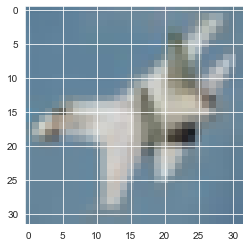

In [47]:
plt.imshow(image_loader(test_image, image_size))

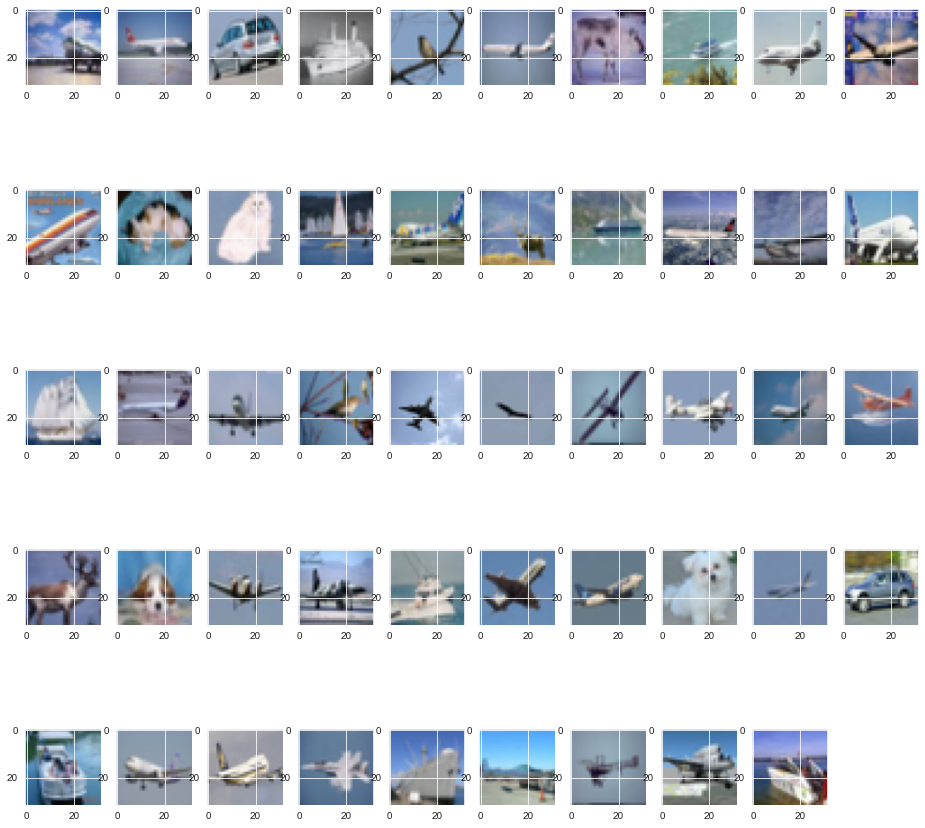

In [48]:
w = 10
h = 10
fig = plt.figure(figsize=(16, 16))
columns = 10
rows = 5
for i in range(1, columns*rows+1):
    try:
        image = image_loader(train_image_paths[result_ids[i]], image_size)
        fig.add_subplot(rows, columns, i)
        plt.imshow(image)
    except:
        pass
plt.show()